In [1]:
import numpy as np
import pandas as pd

data=pd.read_csv("F:\Tutorials\Certified program in MACHINE LEARNING and ARTIFICIAL INTELLIGENCE\Assignments\project\dataset\data.csv",encoding='unicode_escape')
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [2]:
data=data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5836 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5836 non-null   object
 1   Sentiment  5836 non-null   object
dtypes: object(2)
memory usage: 136.8+ KB


In [3]:
#labeling target variable
dict_label= {'positive': 0, 'neutral': 0 , 'negative': 1}
data.Sentiment = data.Sentiment.map(dict_label)
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
2,"For the last quarter of 2010 , Componenta 's n...",0
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0


In [4]:
data.Sentiment.value_counts()

0    4976
1     860
Name: Sentiment, dtype: int64

In [5]:
4976//860

5

## Create the dataframe to be augmented 

In [6]:
dfX=data[data["Sentiment"]==1].reset_index(drop=True)
dfX.head()

,Sentence,Sentiment
0,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
1,Shell's $70 Billion BG Deal Meets Shareholder ...,1
2,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,1
3,$SAP Q1 disappoints as #software licenses down...,1
4,$AAPL afternoon selloff as usual will be bruta...,1


## Data Augmentation by Synonym Replacement 

In [7]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import random 

def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)
#print(stop_words)

def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

In [8]:

dfX_Aug=[]
for k in range(len(dfX)):
    trial_sent = dfX.Sentence[k]
    for n in range(6):
        txt= synonym_replacement(trial_sent,n)
        dfX_Aug.append(txt)

In [9]:
dfXAugmented=pd.DataFrame(dfX_Aug,columns=['Sentence'])
dfXAugmented['Sentiment'] = 1
dfXAugmented.head(10)

,Sentence,Sentiment
0,"$ESI on lows, down $1.50 to $2.50 berkelium a ...",1
1,"$ESI on lows, down $1.50 to $2.50 bk a real po...",1
2,"$ESI on lows, down $1.50 to $2.50 atomic numbe...",1
3,"$ESI on lows, down $1.50 to $2.50 bk a tangibl...",1
4,"$ESI on lows, down $1.50 to $2.50 berkelium a ...",1
5,"$ESI on lows, down $1.50 to $2.50 bk a genuine...",1
6,Shell's $70 Billion BG Deal Meets Shareholder ...,1
7,Shell's $70 Billion BG Deal see Shareholder Sk...,1
8,Shell's $70 Billion BG Deal run across stockho...,1
9,Shell's $70 Billion BG wad fill stockholder Sk...,1


In [10]:
df1=data[data["Sentiment"]==0].reset_index(drop=True)
df2=dfXAugmented
frames = [df1, df2]
  
X = pd.concat(frames)
display(X )

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,0
1,"For the last quarter of 2010 , Componenta 's n...",0
2,According to the Finnish-Russian Chamber of Co...,0
3,The Swedish buyout firm has sold its remaining...,0
4,$SPY wouldn't be surprised to see a green close,0
...,...,...
5155,lift costs have forced packaging producer Huht...,1
5156,RISING costs have forced packaging producer Hu...,1
5157,ascend costs have forced promotion producer Hu...,1
5158,revolt costs have hale publicity producer Huht...,1


In [11]:
X .Sentiment.value_counts()

1    5160
0    4976
Name: Sentiment, dtype: int64

In [12]:
X.to_csv('file_dataAug.csv')

## Split to train and test data 

In [13]:
from sklearn.model_selection import train_test_split
XTrain,XTest=train_test_split(X,test_size=0.2,random_state=42)

# Data Preprocessing

In [14]:
from keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 1000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer=text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(list(XTrain.Sentence))
# Get our training data word index
word_index = tokenizer.word_index
# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(XTrain.Sentence)
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)


print("\nPadded training shape:", train_padded.shape)



Padded training shape: (8108, 58)


In [15]:
test_sequences = tokenizer.texts_to_sequences(XTest.Sentence)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

print("\nPadded testing shape:",test_padded.shape)



Padded testing shape: (2028, 58)


In [16]:
for x, y in zip(XTest.Sentence, test_padded):
  print('{} -> {}'.format(x, y))

print("\nWord index (for reference):", word_index)

The EU Commission said earlier it had fined ThyssenKrupp , United Technologies Corp 's Otis , Schindler atomic number  and Kone Oyj a total of 992.3 mln eur for allege cartel activity in the lift market going back twelve years . -> [  1  34 120  31 142 622 324  11 167  90   5 776  55   6 105   2  23  41
   7   8   3   1  72 433 179 476   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
Atria will also buy the shares of Kauhajoen Teurastamokiinteistot Oy (Kauhajoki slaughterhouse property)from Itikka Co-operative . -> [825  16  95 270   1  74   2 295 975   9  42   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
The numerate of corporeal trauma showcase quadruple in 2000-2006 . -> [ 1  2  3 71  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  

### Create an RNN model + Hyperparameter tuning

In [17]:
X_train,y_train=train_padded,XTrain.Sentiment
X_test,y_test=test_padded,XTest.Sentiment

# train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2, random_state=42,
                                                  stratify=y_train)

In [31]:
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)

import warnings
warnings.filterwarnings("ignore", category=Warning) 
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option("display.max_columns", None)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SimpleRNN,Dropout
score_acc = make_scorer(accuracy_score)


In [27]:
# Create function
def nn_cl_bo2(neurons, optimizer, learning_rate, batch_size, epochs):
    
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    
    neurons = round(neurons)
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    
    def nn_cl_fun():
        nn=Sequential()
        nn.add(Embedding(input_dim=len(word_index)+1,output_dim=128))
        nn.add(SimpleRNN(50))
        nn.add(Dense(neurons, activation='relu'))
        nn.add(Dropout(0.5))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score


In [36]:
params_nn2 ={
    'neurons': (10, 100),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(100, 300),
    'epochs':(20, 90)}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=42)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | batch_... |  epochs   | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------
| 1         | 0.504     | 174.9     | 86.55     | 0.7347    | 63.88     | 1.092     |
| 2         | 0.4958    | 131.2     | 24.07     | 0.8675    | 64.1      | 4.957     |
| 3         | 0.5039    | 104.1     | 87.89     | 0.8341    | 29.11     | 1.273     |
| 4         | 0.496     | 136.7     | 41.3      | 0.5295    | 48.88     | 2.039     |
| 5         | 0.7433    | 222.4     | 29.76     | 0.2992    | 42.97     | 3.192     |
| 6         | 0.5123    | 257.0     | 33.98     | 0.5191    | 63.32     | 0.3252    |
| 7         | 0.5123    | 221.5     | 31.94     | 0.0744    | 95.4      | 6.759     |
| 8         | 0.7584    | 261.7     | 41.32     | 0.1067    | 71.58     | 3.081     |
| 9         | 0.5123    | 124.4     | 54.66     | 0.04404   | 91.84     | 1.811     |
| 10        | 0.5045    | 232.5     | 41.82     | 0.52

NotUniqueError: Data point [2.61679470e+02 4.13229638e+01 1.06695393e-01 7.15809724e+01
 3.08106746e+00] is not unique. You can set "allow_duplicate_points=True" to avoid this error

In [37]:
params_nn_ = nn_bo.max['params']
params_nn_

{'batch_size': 261.6794696232922,
 'epochs': 41.32296384213595,
 'learning_rate': 0.10669539286632003,
 'neurons': 71.58097238609412,
 'optimizer': 3.081067456177209}

In [38]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'batch_size': 262,
 'epochs': 41,
 'learning_rate': 0.10669539286632003,
 'neurons': 72,
 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta at 0x1b0999efb80>}

In [39]:
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=128))
model.add(SimpleRNN(50))
model.add(Dense(72, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adadelta(lr=0.106), metrics=['accuracy'])
model.summary()    

Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_134 (Embedding)    (None, None, 128)         1606016   
_________________________________________________________________
simple_rnn_134 (SimpleRNN)   (None, 50)                8950      
_________________________________________________________________
dense_338 (Dense)            (None, 72)                3672      
_________________________________________________________________
dropout_119 (Dropout)        (None, 72)                0         
_________________________________________________________________
dense_339 (Dense)            (None, 1)                 73        
Total params: 1,618,711
Trainable params: 1,618,711
Non-trainable params: 0
_________________________________________________________________


In [40]:
history=model.fit(X_train,y_train,batch_size=262,epochs=41,verbose=2,validation_data=(X_test,y_test ))

Epoch 1/41
25/25 - 1s - loss: 0.6988 - accuracy: 0.4940 - val_loss: 0.6931 - val_accuracy: 0.4931
Epoch 2/41
25/25 - 1s - loss: 0.6917 - accuracy: 0.5248 - val_loss: 0.6908 - val_accuracy: 0.5207
Epoch 3/41
25/25 - 1s - loss: 0.6869 - accuracy: 0.5476 - val_loss: 0.6774 - val_accuracy: 0.5863
Epoch 4/41
25/25 - 1s - loss: 0.6727 - accuracy: 0.5873 - val_loss: 0.6806 - val_accuracy: 0.5577
Epoch 5/41
25/25 - 1s - loss: 0.6562 - accuracy: 0.6252 - val_loss: 0.6573 - val_accuracy: 0.6149
Epoch 6/41
25/25 - 1s - loss: 0.6382 - accuracy: 0.6608 - val_loss: 0.6113 - val_accuracy: 0.6953
Epoch 7/41
25/25 - 1s - loss: 0.6137 - accuracy: 0.6852 - val_loss: 0.6159 - val_accuracy: 0.6731
Epoch 8/41
25/25 - 1s - loss: 0.5718 - accuracy: 0.7259 - val_loss: 0.5735 - val_accuracy: 0.7179
Epoch 9/41
25/25 - 1s - loss: 0.5510 - accuracy: 0.7365 - val_loss: 0.5950 - val_accuracy: 0.7017
Epoch 10/41
25/25 - 1s - loss: 0.5247 - accuracy: 0.7589 - val_loss: 0.5443 - val_accuracy: 0.7411
Epoch 11/41
25/25 -

In [42]:
history=model.fit(X_train,y_train,batch_size=262,epochs=40,verbose=2,validation_data=(X_test,y_test ))

Epoch 1/40
25/25 - 1s - loss: 0.2074 - accuracy: 0.9204 - val_loss: 0.5169 - val_accuracy: 0.8037
Epoch 2/40
25/25 - 1s - loss: 0.2051 - accuracy: 0.9226 - val_loss: 0.5189 - val_accuracy: 0.8082
Epoch 3/40
25/25 - 1s - loss: 0.2024 - accuracy: 0.9221 - val_loss: 0.5312 - val_accuracy: 0.8037
Epoch 4/40
25/25 - 1s - loss: 0.1996 - accuracy: 0.9228 - val_loss: 0.5287 - val_accuracy: 0.8023
Epoch 5/40
25/25 - 1s - loss: 0.1974 - accuracy: 0.9223 - val_loss: 0.5386 - val_accuracy: 0.7973
Epoch 6/40
25/25 - 1s - loss: 0.1918 - accuracy: 0.9286 - val_loss: 0.5393 - val_accuracy: 0.7978
Epoch 7/40
25/25 - 1s - loss: 0.1894 - accuracy: 0.9258 - val_loss: 0.5501 - val_accuracy: 0.8062
Epoch 8/40
25/25 - 1s - loss: 0.1827 - accuracy: 0.9300 - val_loss: 0.5631 - val_accuracy: 0.7978
Epoch 9/40
25/25 - 1s - loss: 0.1795 - accuracy: 0.9345 - val_loss: 0.5807 - val_accuracy: 0.7909
Epoch 10/40
25/25 - 1s - loss: 0.1768 - accuracy: 0.9335 - val_loss: 0.5698 - val_accuracy: 0.7914
Epoch 11/40
25/25 -

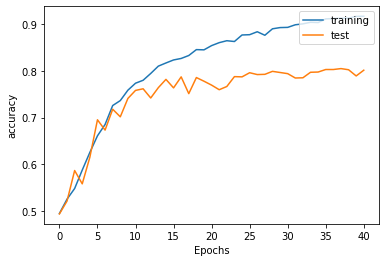

In [41]:
import matplotlib.pyplot as plt
metrics='accuracy'
plt.plot(history.history[metrics])
plt.plot(history.history['val_'+ metrics])
plt.xlabel('Epochs')
plt.ylabel(metrics)
plt.legend(['training', 'test'], loc='upper right')
plt.show()
     

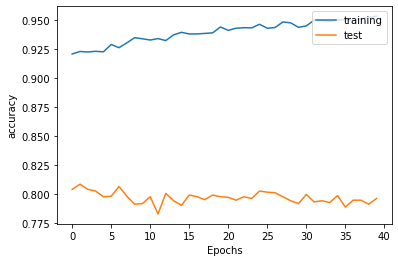

In [43]:
import matplotlib.pyplot as plt
metrics='accuracy'
plt.plot(history.history[metrics])
plt.plot(history.history['val_'+ metrics])
plt.xlabel('Epochs')
plt.ylabel(metrics)
plt.legend(['training', 'test'], loc='upper right')
plt.show()
     